In [2]:
# Market Basket Analysis (Online Retail) - Notebook
# Author: Laxman Maheshwaram
# Date: 2025-08-14

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from mlxtend.frequent_patterns import apriori, association_rules

# ensure images & data dir exist (notebooks is inside project)
os.makedirs("../images", exist_ok=True)
os.makedirs("../data", exist_ok=True)

sns.set(style="whitegrid")


In [5]:
# 1) Load Online Retail dataset (Excel)
# Place the downloaded file at: market-basket-analysis/data/online_retail.xlsx
local_path = "/Users/laxmanmaheshwaram/market-basket_analysis/data/Online_Retail.xlsx"

if os.path.exists(local_path):
    print("Loading local file:", local_path)
    df = pd.read_excel(local_path, engine="openpyxl")
else:
    # Helpful message when file not present
    raise FileNotFoundError(
        "Please download 'Online Retail' Excel file and save it to:\n"
        "  market-basket-analysis/data/online_retail.xlsx\n\n"
        "UCI dataset URL (manual download recommended if SSL issues):\n"
        "  https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx\n"
    )

print("Raw rows:", df.shape[0])
df.head()


Loading local file: /Users/laxmanmaheshwaram/market-basket_analysis/data/Online_Retail.xlsx
Raw rows: 541909


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
# 2) Basic cleaning + filter to United Kingdom, remove returns/cancellations
# Remove rows with missing Description or InvoiceNo
df = df.dropna(subset=["Description", "InvoiceNo"])

# Keep only United Kingdom to reduce product variety/noise
if "Country" in df.columns:
    df = df[df["Country"].str.strip().str.lower() == "united kingdom"]

# Remove cancelled orders: InvoiceNo starting with 'C'
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]

# Keep only positive quantities
df = df[df["Quantity"] > 0]

print("Rows after filtering:", df.shape[0])
display(df.head())


Rows after filtering: 485694


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
# 3) Create invoice-level basket (InvoiceNo x Description)
# Aggregate quantity per invoice/description then convert to presence (1/0)
basket = (
    df.groupby(["InvoiceNo", "Description"])["Quantity"]
    .sum()
    .unstack(fill_value=0)
)

# Convert quantities to 1/0 (presence)
basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)

print("Basket shape (invoices x items):", basket_sets.shape)
basket_sets.iloc[:5, :10]  # show first 5 invoices, first 10 items


/var/folders/_c/dv_bw7b10tb5vlqg260d4rx80000gn/T/ipykernel_4065/2263234445.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)


Basket shape (invoices x items): (18194, 4058)


Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT
InvoiceNo,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0


In [8]:
# 4) Optional: to make the problem tractable, keep top-K most frequent items
# If you want full dataset, skip this block. For faster runs keep top 200 items.
top_k = 200           # <= number of unique items; set None to keep all
if top_k is not None:
    item_counts = basket_sets.sum().sort_values(ascending=False)
    top_items = item_counts.head(top_k).index
    basket_sets = basket_sets[top_items]
    print("Reduced basket to top", top_k, "items. New shape:", basket_sets.shape)


Reduced basket to top 200 items. New shape: (18194, 200)


In [9]:
# 5) Apriori: find frequent itemsets
# min_support chosen to balance quantity vs noise: try 0.02 (2%) or 0.01 (1%)
min_support = 0.02
frequent_itemsets = apriori(basket_sets, min_support=min_support, use_colnames=True, verbose=1)
frequent_itemsets = frequent_itemsets.sort_values(by="support", ascending=False).reset_index(drop=True)

print("Frequent itemsets found:", len(frequent_itemsets))
frequent_itemsets.head(10)

# Save frequent itemsets for record
frequent_itemsets.to_csv("../data/frequent_itemsets.csv", index=False)
print("Saved frequent itemsets -> ../data/frequent_itemsets.csv")


/Users/laxmanmaheshwaram/market-basket_analysis/.venv/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Processing 40 combinations | Sampling itemset size 4 32
Frequent itemsets found: 296
Saved frequent itemsets -> ../data/frequent_itemsets.csv


In [10]:
# 6) Generate association rules
# Use lift (>=1) or increase threshold. We'll generate with lift and then filter.
min_lift = 1.2        # set higher for stronger associations
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=min_lift)

# If empty, try lowering thresholds (we'll check and print guidance)
if rules.empty:
    print("No rules found with min_support =", min_support, "and min_lift =", min_lift)
    print("Try lowering min_support (e.g., 0.01) or min_lift (e.g., 1.0)")
else:
    rules = rules.sort_values(by="lift", ascending=False).reset_index(drop=True)
    print("Rules found:", len(rules))
    display(rules.head(10))
    # Save rules
    rules.to_csv("../data/association_rules.csv", index=False)
    print("Saved rules -> ../data/association_rules.csv")


Rules found: 208


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(WOODEN HEART CHRISTMAS SCANDINAVIAN),(WOODEN STAR CHRISTMAS SCANDINAVIAN),0.027976,0.026327,0.020226,0.722986,27.461402,1.0,0.019490,3.514889,0.991319,0.593548,0.715496,0.745627
1,(WOODEN STAR CHRISTMAS SCANDINAVIAN),(WOODEN HEART CHRISTMAS SCANDINAVIAN),0.026327,0.027976,0.020226,0.768267,27.461402,1.0,0.019490,4.194589,0.989640,0.593548,0.761598,0.745627
2,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",0.038639,0.038529,0.027097,0.701280,18.201273,1.0,0.025608,3.218638,0.983043,0.541164,0.689310,0.702281
3,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",(PINK REGENCY TEACUP AND SAUCER),0.038529,0.038639,0.027097,0.703281,18.201273,1.0,0.025608,3.239971,0.982930,0.541164,0.691355,0.702281
4,(GREEN REGENCY TEACUP AND SAUCER),"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",0.051336,0.030010,0.027097,0.527837,17.588775,1.0,0.025556,2.054355,0.994183,0.499493,0.513229,0.715384
5,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.030010,0.051336,0.027097,0.902930,17.588775,1.0,0.025556,9.773033,0.972325,0.499493,0.897678,0.715384
6,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.031714,0.052600,0.027097,0.854419,16.243790,1.0,0.025429,6.507737,0.969174,0.473583,0.846337,0.684785
7,(ROSES REGENCY TEACUP AND SAUCER ),"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",0.052600,0.031714,0.027097,0.515152,16.243790,1.0,0.025429,1.997090,0.990540,0.473583,0.499272,0.684785
8,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.051336,0.038639,0.031714,0.617773,15.988282,1.0,0.029730,2.515157,0.988183,0.544340,0.602411,0.719271
9,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.038639,0.051336,0.031714,0.820768,15.988282,1.0,0.029730,5.292945,0.975132,0.544340,0.811069,0.719271


Saved rules -> ../data/association_rules.csv


In [11]:
# 7) Auto-adjust: if no rules, try looser thresholds automatically
if rules.empty:
    print("Attempting looser thresholds automatically...")
    frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)
    if rules.empty:
        print("Still no rules. Consider increasing dataset size (use all countries) or lowering thresholds further.")
    else:
        rules = rules.sort_values(by="confidence", ascending=False).reset_index(drop=True)
        print("Fallback rules found:", len(rules))
        display(rules.head(10))
        rules.to_csv("../data/association_rules_fallback.csv", index=False)
        print("Saved fallback rules -> ../data/association_rules_fallback.csv")


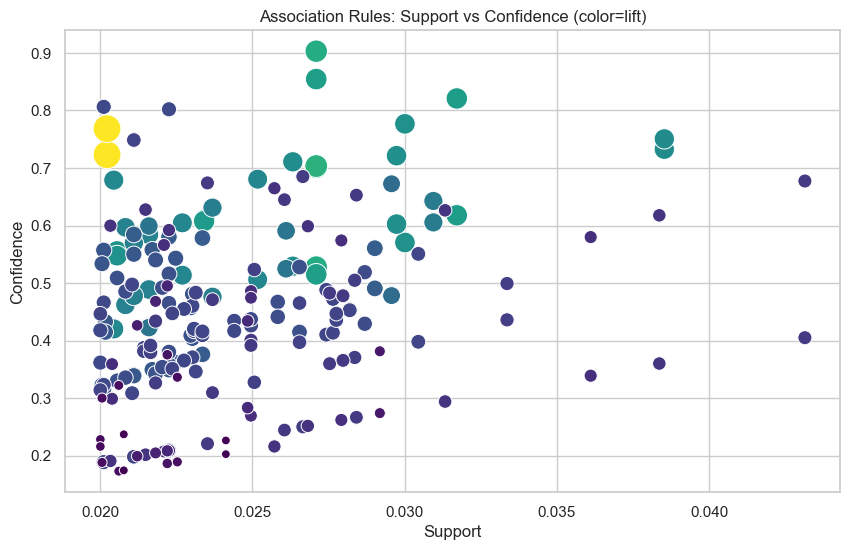

Saved plot -> ../images/lift_confidence_scatter.png


In [12]:
# 8) Visualization: scatter plot of rules (if present)
if not rules.empty:
    plt.figure(figsize=(10, 6))
    s = (rules["lift"] - rules["lift"].min()) / (rules["lift"].max() - rules["lift"].min() + 1e-9)
    sizes = 100 + 400 * s
    sns.scatterplot(x="support", y="confidence", size=sizes, sizes=(40, 400),
                    hue="lift", palette="viridis", data=rules, legend=False)
    plt.title("Association Rules: Support vs Confidence (color=lift)")
    plt.xlabel("Support")
    plt.ylabel("Confidence")
    plt.savefig("../images/lift_confidence_scatter.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved plot -> ../images/lift_confidence_scatter.png")
else:
    print("No rules to plot.")


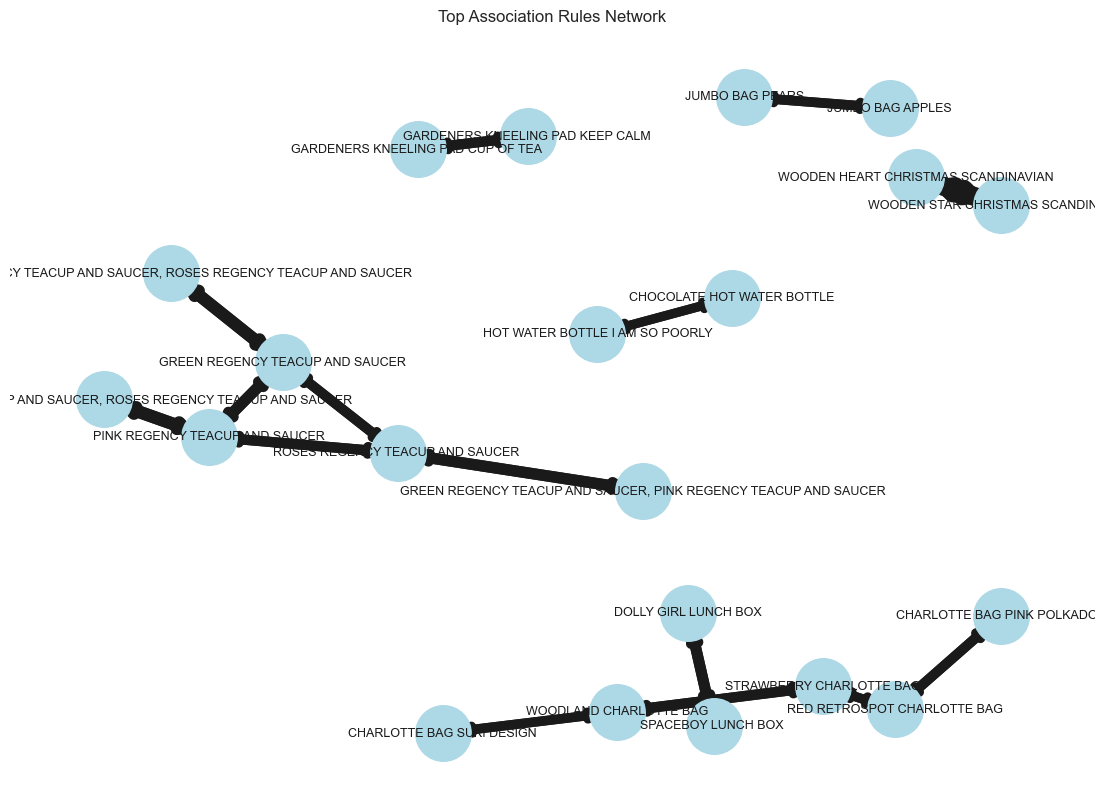

Saved network -> ../images/association_rules_network.png


In [13]:
# 9) Network graph of top rules for visualization
if not rules.empty:
    top_n = min(30, len(rules))
    top_rules = rules.head(top_n).copy()

    G = nx.DiGraph()
    for _, row in top_rules.iterrows():
        # antecedents and consequents are frozensets — convert to strings
        a = ", ".join(sorted(list(row["antecedents"])))
        c = ", ".join(sorted(list(row["consequents"])))
        G.add_node(a)
        G.add_node(c)
        G.add_edge(a, c, weight=row["lift"], label=f"lift={row['lift']:.2f}\nconf={row['confidence']:.2f}")

    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G, k=1.5, seed=42)
    nx.draw_networkx_nodes(G, pos, node_size=1600, node_color="lightblue")
    nx.draw_networkx_labels(G, pos, font_size=9)
    edges = G.edges()
    weights = [G[u][v]["weight"] for u, v in edges]
    nx.draw_networkx_edges(G, pos, arrowstyle="-|>", arrowsize=12, width=[max(0.5, w/2) for w in weights])
    plt.title("Top Association Rules Network")
    plt.axis("off")
    plt.savefig("../images/association_rules_network.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved network -> ../images/association_rules_network.png")


In [14]:
# 10) Auto-update README with latest images (simple)
from jinja2 import Template

template_md = """# Market Basket Analysis (Online Retail)

This project finds association rules from the Online Retail dataset.

## Example visualizations
{% for img in images %}
### {{ img.title }}
![{{ img.title }}]({{ img.path }})
{% endfor %}
"""

image_files = [f for f in sorted(os.listdir("../images")) if f.lower().endswith(('.png','.jpg','.jpeg'))]
images = [{"title": os.path.splitext(f)[0].replace("_", " ").title(), "path": f"images/{f}"} for f in image_files]

readme_text = Template(template_md).render(images=images)
with open("../README.md", "w") as fh:
    fh.write(readme_text)

print("README.md updated with images (../README.md)")


README.md updated with images (../README.md)
